In [ ]:
import nltk
nltk.download('reuters')
!unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

Streaming output truncated to the last 5000 lines.
  inflating: /root/nltk_data/corpora/reuters/training/2231  
  inflating: /root/nltk_data/corpora/reuters/training/2232  
  inflating: /root/nltk_data/corpora/reuters/training/2234  
  inflating: /root/nltk_data/corpora/reuters/training/2236  
  inflating: /root/nltk_data/corpora/reuters/training/2237  
  inflating: /root/nltk_data/corpora/reuters/training/2238  
  inflating: /root/nltk_data/corpora/reuters/training/2239  
  inflating: /root/nltk_data/corpora/reuters/training/2240  
  inflating: /root/nltk_data/corpora/reuters/training/2244  
  inflating: /root/nltk_data/corpora/reuters/training/2246  
  inflating: /root/nltk_data/corpora/reuters/training/2247  
  inflating: /root/nltk_data/corpora/reuters/training/2249  
  inflating: /root/nltk_data/corpora/reuters/training/225  
  inflating: /root/nltk_data/corpora/reuters/training/2251  
  inflating: /root/nltk_data/corpora/reuters/training/2252  
  inflating: /root/nltk_data/corpor

In [ ]:
from nltk.corpus import reuters
print(len(reuters.fileids('crude')))
print(reuters.categories())

578
['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk', 'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut', 'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt', 'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead', 'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx', 'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nzdlr', 'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palmkernel', 'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil', 'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship', 'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean', 'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sunseed', 'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc']


In [ ]:
data = reuters.fileids('crude')[:100]
news = []
for d in data:
  words = reuters.words(d)
  news.append(' '.join(words))

print(news[10])

U . S . ENERGY FUTURES CALLED UNCHANGED TO LOWER Traders expect U . S . energy futures will open unchanged to slightly lower this morning with support near yesterday ' s lows . Crude futures are called unchanged to five cts weaker tracking unchanged domestic crudes and North Sea Brent crude , which traded at 18 . 01 dlrs a barrel today , about ten cts below yesterday ' s New York close . Traders said the supply squeeze in 15 - day forward April Brent appears to have ended . Product futures , which fell sharply yesterday , are due to open unchanged to 0 . 25 cent lower , traders said . Traders expect some followthrough selling in products but said gasoil futures in London will probably lend some support since they are trading as expected . May gasoil futures were off 1 . 50 dlrs a tonne this morning while June was down 1 . 25 dlrs in thin conditions .


In [ ]:
import re
import numpy as np

def create_unique_word_dict(text:list) -> dict:
    """
    A method that creates a dictionary where the keys are unique words
    and key values are indices
    """
    # Getting all the unique words from our text and sorting them alphabetically
    words = list(set(text))
    words.sort()

    # Creating the dictionary for the unique words
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({
            word: i
        })

    return unique_word_dict    

def text_preprocessing(
    text:list,
    punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
    stop_words=['and', 'a', 'is', 'the', 'in', 'be', 'will']
    )->list:
    """
    A method to preproces text
    """
    for x in text.lower(): 
        if x in punctuations: 
            text = text.replace(x, "")

    # Removing words that have numbers in them
    text = re.sub(r'\w*\d\w*', '', text)

    # Removing digits
    text = re.sub(r'[0-9]+', '', text)

    # Cleaning the whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Setting every word to lower
    text = text.lower()

    # Converting all our text to a list 
    text = text.split(' ')

    # Droping empty strings
    text = [x for x in text if x!='']

    # Droping stop words
    text = [x for x in text if x not in stop_words]

    return text

# Functions to find the most similar word 
def euclidean(vec1:np.array, vec2:np.array) -> float:
    """
    A function to calculate the euclidean distance between two vectors
    """
    return np.sqrt(np.sum((vec1 - vec2)**2))

def find_similar(word:str, embedding_dict:dict, top_n=10)->list:
    """
    A method to find the most similar word based on the learnt embeddings
    """
    dist_dict = {}
    word_vector = embedding_dict.get(word, [])
    if len(word_vector) > 0:
        for key, value in embedding_dict.items():
            if key!=word:
                dist = euclidean(word_vector, value)
                dist_dict.update({
                    key: dist
                })

        return sorted(dist_dict.items(), key=lambda x: x[1])[0:top_n]       

In [ ]:
import itertools
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm

# Drawing the embeddings
import matplotlib.pyplot as plt

# Deep learning: 
from keras.models import Input, Model
from keras.layers import Dense

from scipy import sparse

texts = news

# Defining the window for context
window = 2

# Creating a placeholder for the scanning of the word list
word_lists = []
all_text = []

for text in texts:

    # Cleaning the text
    text = text_preprocessing(text)

    # Appending to the all text list
    all_text += text 

    # Creating a context dictionary
    for i, word in enumerate(text):
        for w in range(window):
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text): 
                word_lists.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words    
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])

unique_word_dict = create_unique_word_dict(all_text)

# Defining the number of features (unique words)
n_words = len(unique_word_dict)
print("number of uniques", n_words)

# Getting all the unique words 
words = list(unique_word_dict.keys())
print("words are", words)

# Creating the X and Y matrices using one hot encoding
X = []
Y = []

for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])

    # Creating the placeholders   
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words 
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

# Converting the matrices into a sparse format because the vast majority of the data are 0s
X = sparse.csr_matrix(X)
Y = sparse.csr_matrix(Y)      

number of uniques 2728
words are ['abandoned', 'abandoning', 'abatements', 'abdul', 'able', 'abolished', 'about', 'above', 'absorption', 'abu', 'accept', 'acceptance', 'accepted', 'accomodate', 'accord', 'accordance', 'according', 'accordingly', 'accords', 'account', 'accounted', 'accounting', 'accounts', 'accumulated', 'acquire', 'acquired', 'acquires', 'acquisition', 'acquisitions', 'acre', 'acres', 'across', 'action', 'actions', 'actively', 'activity', 'acts', 'actually', 'add', 'added', 'adding', 'addition', 'adds', 'adherence', 'adjusted', 'adjustment', 'adjustments', 'administration', 'admit', 'admitted', 'adnoc', 'adopted', 'adoption', 'adrian', 'advance', 'adversely', 'advised', 'advisory', 'advocated', 'aegean', 'aerial', 'affairs', 'affected', 'affecting', 'affiliated', 'after', 'afternoon', 'again', 'against', 'agencies', 'agency', 'agenda', 'aggression', 'aggressively', 'agip', 'ago', 'agree', 'agreed', 'agreeing', 'agreement', 'agreements', 'agrement', 'agrio', 'ahead', 'a

56416it [00:01, 29213.96it/s]


In [ ]:
print(X.shape)
print(Y.shape)

(56416, 2728)
(56416, 2728)


In [ ]:
# Defining the size of the embedding
embed_size = 2

# Defining the neural network
inp = Input(shape=(X.shape[1],))
x = Dense(units=embed_size, activation='linear')(inp)
x = Dense(units=Y.shape[1], activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

# Optimizing the network weights
model.fit(
    x=X.todense(), 
    y=Y.todense(), 
    batch_size=256,
    epochs=1000,
    )

# Obtaining the weights from the neural network. 
# These are the so called word embeddings

# The input layer 
weights = model.get_weights()[0]

# Creating a dictionary to store the embeddings in. The key is a unique word and 
# the value is the numeric vector
embedding_dict = {}
for word in words: 
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
        })

Epoch 1/1000
221/221 [==============================] - 3s 7ms/step - loss: 7.7901
Epoch 2/1000
221/221 [==============================] - 1s 7ms/step - loss: 7.3394
Epoch 3/1000
221/221 [==============================] - 1s 7ms/step - loss: 6.8753
Epoch 4/1000
221/221 [==============================] - 1s 7ms/step - loss: 6.6728
Epoch 5/1000
221/221 [==============================] - 2s 7ms/step - loss: 6.6289
Epoch 6/1000
221/221 [==============================] - 1s 7ms/step - loss: 6.6153
Epoch 7/1000
221/221 [==============================] - 1s 7ms/step - loss: 6.6077
Epoch 8/1000
221/221 [==============================] - 2s 7ms/step - loss: 6.6025
Epoch 9/1000
221/221 [==============================] - 2s 7ms/step - loss: 6.5987
Epoch 10/1000
221/221 [==============================] - 2s 7ms/step - loss: 6.5958
Epoch 11/1000
221/221 [==============================] - 2s 7ms/step - loss: 6.5934
Epoch 12/1000
221/221 [==============================] - 1s 7ms/step - loss: 6.5913
E

In [ ]:
model.save("model.h5")

In [ ]:
# model = create_model()

# # Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

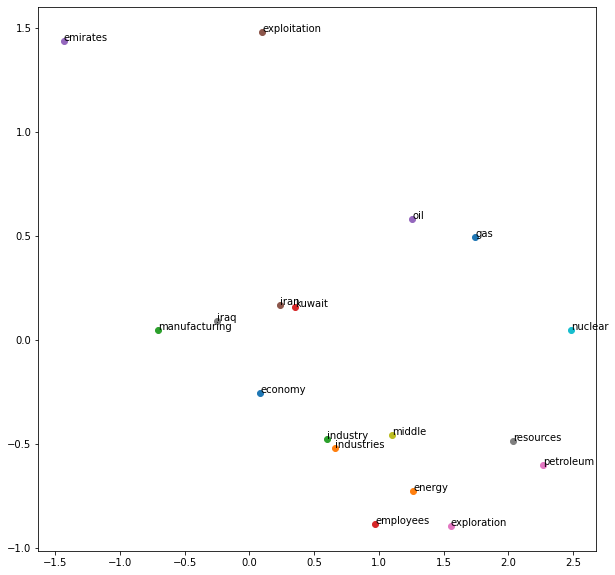

In [ ]:
# Ploting the embeddings
plt.figure(figsize=(10, 10))
plt_words = ['gas', 'energy', 'industry', 'kuwait', 'oil', 'iran', 'petroleum', 'iraq',
            'middle', 'nuclear', 'economy', 'industries', 'manufacturing', 'employees',
            'emirates', 'exploitation', 'exploration', 'resources']
# for word in list(unique_word_dict.keys()):
for word in plt_words:
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))     

In [ ]:
# Saving the embedding vector to a txt file
try:
    os.mkdir(f'{os.getcwd()}\\output')        
except Exception as e:
    print(f'Cannot create output folder: {e}')

with open(f'{os.getcwd()}\\output\\embedding.txt', 'w') as f:
    for key, value in embedding_dict.items():
        try:
            f.write(f'{key}: {value}\n')   
        except Exception as e:
            print(f'Cannot write word {key} to dict: {e}')  

In [ ]:
find_similar('iran', embedding_dict)

[('communication', 0.05752556),
 ('talking', 0.06276985),
 ('supply', 0.06379738),
 ('supplies', 0.068744384),
 ('increased', 0.07603855),
 ('producer', 0.08262307),
 ('agreement', 0.08572599),
 ('annual', 0.09117655),
 ('settlement', 0.10088544),
 ('inch', 0.1010083)]

In [ ]:
find_similar('aware', embedding_dict)

[('agrement', 0.026115535),
 ('something', 0.037052095),
 ('algerians', 0.03987449),
 ('ships', 0.058817934),
 ('follow', 0.10351497),
 ('arrangement', 0.10861039),
 ('condtions', 0.115833566),
 ('re', 0.12418954),
 ('leblanc', 0.13774122),
 ('patrolling', 0.1491283)]

In [ ]:
find_similar('chemical', embedding_dict)

[('shared', 0.04978026),
 ('haul', 0.073777765),
 ('interview', 0.082462475),
 ('increasingly', 0.08389077),
 ('conference', 0.09578442),
 ('elton', 0.12656514),
 ('dispute', 0.13524054),
 ('commitments', 0.13561176),
 ('firm', 0.14931321),
 ('begun', 0.15001611)]

In [ ]:
find_similar('game', embedding_dict)

[('washed', 0.012840512),
 ('continuing', 0.02740974),
 ('order', 0.068424046),
 ('guided', 0.088363744),
 ('declines', 0.0884255),
 ('bringing', 0.08874848),
 ('efficiency', 0.09543699),
 ('related', 0.09631377),
 ('few', 0.09893306),
 ('determine', 0.111413434)]

In [ ]:
find_similar('king', embedding_dict)

[('fleet', 0.06290099),
 ('pace', 0.090319775),
 ('algerian', 0.13734749),
 ('synar', 0.15411422),
 ('flag', 0.16426693),
 ('leftist', 0.1696439),
 ('cheyenne', 0.18403526),
 ('mees', 0.210704),
 ('senate', 0.2523317),
 ('oilsands', 0.27696994)]

In [ ]:
find_similar('jungle', embedding_dict)

[('heart', 0.22345117),
 ('reference', 0.26099488),
 ('annum', 0.3571673),
 ('oilfields', 0.36861652),
 ('lighter', 0.3841773),
 ('collapsed', 0.43634808),
 ('nine', 0.4437281),
 ('marginally', 0.45145908),
 ('faces', 0.48300773),
 ('metric', 0.48596492)]

In [ ]:
find_similar('justice', embedding_dict)

[('backed', 0.032110613),
 ('consuming', 0.07040953),
 ('for', 0.08582186),
 ('proration', 0.10396621),
 ('india', 0.104285814),
 ('reduced', 0.11137408),
 ('adherence', 0.11648192),
 ('of', 0.12503901),
 ('while', 0.12536553),
 ('demand', 0.13178091)]

In [ ]:
find_similar('liquid', embedding_dict)

[('hisham', 0.029936995),
 ('pemex', 0.13449763),
 ('newspaper', 0.15520826),
 ('role', 0.22846349),
 ('arne', 0.31394124),
 ('handles', 0.31578523),
 ('nicolas', 0.3315981),
 ('vice', 0.38919786),
 ('commissioner', 0.4784465),
 ('banking', 0.5018538)]

In [ ]:
find_similar('magazine', embedding_dict)

[('ministry', 0.031643894),
 ('headlined', 0.08395784),
 ('luck', 0.107106395),
 ('texaco', 0.10949006),
 ('investigating', 0.12191331),
 ('resolves', 0.1264792),
 ('latest', 0.13640684),
 ('filed', 0.13999522),
 ('warship', 0.14221585),
 ('including', 0.1424357)]

In [ ]:
find_similar('march', embedding_dict)

[('sent', 0.0469787),
 ('buyers', 0.048151672),
 ('trying', 0.052773602),
 ('earlier', 0.06430248),
 ('runs', 0.07600357),
 ('shortages', 0.09555915),
 ('freight', 0.097296596),
 ('organisation', 0.102082565),
 ('demanding', 0.103012286),
 ('adversely', 0.10455601)]

In [ ]:
find_similar('office', embedding_dict)

[('managing', 0.07630646),
 ('county', 0.1281036),
 ('accounting', 0.13332489),
 ('papandreou', 0.14882746),
 ('team', 0.15163507),
 ('liberation', 0.16464165),
 ('weld', 0.16473697),
 ('businessmen', 0.19838585),
 ('morton', 0.21138544),
 ('gaf', 0.21305408)]

In [ ]:
find_similar('opinions', embedding_dict)

[('stay', 0.008029337),
 ('whether', 0.04556841),
 ('refining', 0.063542396),
 ('military', 0.06502655),
 ('their', 0.08707795),
 ('find', 0.092248194),
 ('want', 0.09548855),
 ('already', 0.100033216),
 ('refused', 0.11032065),
 ('unwilling', 0.11867756)]

In [ ]:
find_similar('orange', embedding_dict)

[('mhc', 0.077663526),
 ('reaches', 0.10252834),
 ('directors', 0.12101354),
 ('alberta', 0.12394682),
 ('intelligence', 0.1420073),
 ('mercantile', 0.17690654),
 ('public', 0.18822142),
 ('bankruptcy', 0.19440661),
 ('excise', 0.19789486),
 ('often', 0.21637796)]

In [ ]:
find_similar('permit', embedding_dict)

[('bpd', 0.06646277),
 ('spot', 0.08208872),
 ('flow', 0.09260246),
 ('anywhere', 0.09496273),
 ('face', 0.10990042),
 ('around', 0.12192655),
 ('always', 0.16856775),
 ('bass', 0.17754589),
 ('ghana', 0.17969704),
 ('strength', 0.17975514)]

In [ ]:
find_similar('plans', embedding_dict)

[('virtual', 0.054799605),
 ('time', 0.061884046),
 ('slow', 0.06579646),
 ('abandoned', 0.08290788),
 ('tonne', 0.08370163),
 ('reasonable', 0.084283516),
 ('before', 0.08448119),
 ('demonstrated', 0.09858507),
 ('offer', 0.101060845),
 ('quota', 0.10248064)]

In [ ]:
find_similar('policy', embedding_dict)

[('flexible', 0.03789894),
 ('started', 0.0462742),
 ('compliance', 0.05202387),
 ('sunday', 0.060468942),
 ('news', 0.06214684),
 ('departure', 0.06807182),
 ('continues', 0.07922864),
 ('estimated', 0.089262985),
 ('special', 0.0911855),
 ('analysts', 0.0938376)]

In [ ]:
find_similar('recommend', embedding_dict)

[('crises', 0.04587473),
 ('assets', 0.056138862),
 ('concern', 0.059515487),
 ('partners', 0.06474386),
 ('stark', 0.07519542),
 ('threatened', 0.07790154),
 ('abolished', 0.096375786),
 ('contracted', 0.10045632),
 ('ministers', 0.10108764),
 ('downtrend', 0.10764852)]

In [ ]:
find_similar('result', embedding_dict)

[('doubles', 0.016770946),
 ('enabling', 0.036904674),
 ('projection', 0.055313494),
 ('four', 0.09924387),
 ('attempt', 0.105325334),
 ('sustain', 0.10745359),
 ('until', 0.11090214),
 ('saturday', 0.11234525),
 ('world', 0.11586115),
 ('renew', 0.116907395)]

In [ ]:
find_similar('search', embedding_dict)

[('major', 0.031116635),
 ('hopes', 0.038483668),
 ('windfall', 0.045430854),
 ('balance', 0.046093646),
 ('dependency', 0.052504282),
 ('allocations', 0.07205171),
 ('line', 0.07308901),
 ('iea', 0.07570749),
 ('bought', 0.07669883),
 ('approval', 0.089478634)]

In [ ]:
find_similar('sell', embedding_dict)

[('unload', 0.12289544),
 ('formal', 0.1902715),
 ('successfully', 0.25753945),
 ('welcome', 0.283258),
 ('outside', 0.34360418),
 ('flooded', 0.36739007),
 ('disincentive', 0.36874974),
 ('advocated', 0.37517425),
 ('confidence', 0.40814194),
 ('wounded', 0.4232524)]

In [ ]:
find_similar('shopping', embedding_dict)

[('if', 0.034253813),
 ('choice', 0.044045825),
 ('guarding', 0.04634614),
 ('have', 0.04818659),
 ('lot', 0.053554747),
 ('deductible', 0.05834617),
 ('trauma', 0.06266506),
 ('manufacturing', 0.06516645),
 ('discuss', 0.07485651),
 ('message', 0.076239675)]

In [ ]:
find_similar('try', embedding_dict)

[('acceptance', 0.015384329),
 ('provide', 0.06249265),
 ('steepest', 0.0876164),
 ('preserving', 0.23188618),
 ('strengthen', 0.25466636),
 ('row', 0.25517008),
 ('mothball', 0.2934271),
 ('concerns', 0.34879676),
 ('minimal', 0.35109174),
 ('brave', 0.36785516)]

In [ ]:
find_similar('worry', embedding_dict)

[('although', 0.03466444),
 ('war', 0.039529204),
 ('usual', 0.053450696),
 ('developments', 0.065179996),
 ('fact', 0.07259121),
 ('downtrend', 0.08205462),
 ('ground', 0.08679173),
 ('wants', 0.10754706),
 ('vigorous', 0.109682664),
 ('partners', 0.11660015)]